# AIOps Demonstration Notebook


In [1]:
# Step 1: Setup Environment
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [45]:
# Step 2: Load and Explore Data
import pandas as pd
import numpy as np

# Load your datasets
server_metrics = pd.read_csv("data/netflix_operational_metrics.csv")
business_metrics = pd.read_csv("data/netflix_business_metrics.csv")

# Display basic information and statistics
print(server_metrics.info())
print(server_metrics.describe())

print(business_metrics.info())
print(business_metrics.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      10080 non-null  object 
 1   CPU Utilization (%)            10080 non-null  float64
 2   Memory Utilization (%)         10080 non-null  float64
 3   Network I/O Throughput (Mbps)  10080 non-null  float64
 4   Disk I/O Throughput (MB/s)     10080 non-null  float64
 5   Server Configuration           10080 non-null  object 
dtypes: float64(4), object(2)
memory usage: 472.6+ KB
None
       CPU Utilization (%)  Memory Utilization (%)  \
count         10080.000000            10080.000000   
mean             69.975567               60.169587   
std              10.973602               10.675025   
min               0.000000                0.000000   
25%              62.757592               53.102970   
50%              69.894974   

In [54]:
# Step 3: Data Preprocessing

# Fill missing values with the mean for numeric columns, preserving the Timestamp column
server_metrics_numeric = server_metrics.select_dtypes(include="number").fillna(
    server_metrics.select_dtypes(include="number").mean()
)
server_metrics = server_metrics.drop(columns=server_metrics_numeric.columns).join(
    server_metrics_numeric
)

business_metrics_numeric = business_metrics.select_dtypes(include="number").fillna(
    business_metrics.select_dtypes(include="number").mean()
)
business_metrics = business_metrics.drop(columns=business_metrics_numeric.columns).join(
    business_metrics_numeric
)

# Print columns to ensure 'Timestamp' is preserved
print("Server Metrics Columns After Preprocessing:")
print(server_metrics.columns)

print("Business Metrics Columns After Preprocessing:")
print(business_metrics.columns)

print("Data Preprocessing Completed.")

Server Metrics Columns After Preprocessing:
Index(['Server Configuration', 'CPU Utilization (%)', 'Memory Utilization (%)',
       'Network I/O Throughput (Mbps)', 'Disk I/O Throughput (MB/s)',
       'Cluster'],
      dtype='object')
Business Metrics Columns After Preprocessing:
Index(['Server Configuration', 'Response Time (ms)',
       'Customer Satisfaction (CSAT)', 'Operational Costs ($)',
       'Service Uptime (%)'],
      dtype='object')
Data Preprocessing Completed.


Silhouette Score: 0.2713461517049416


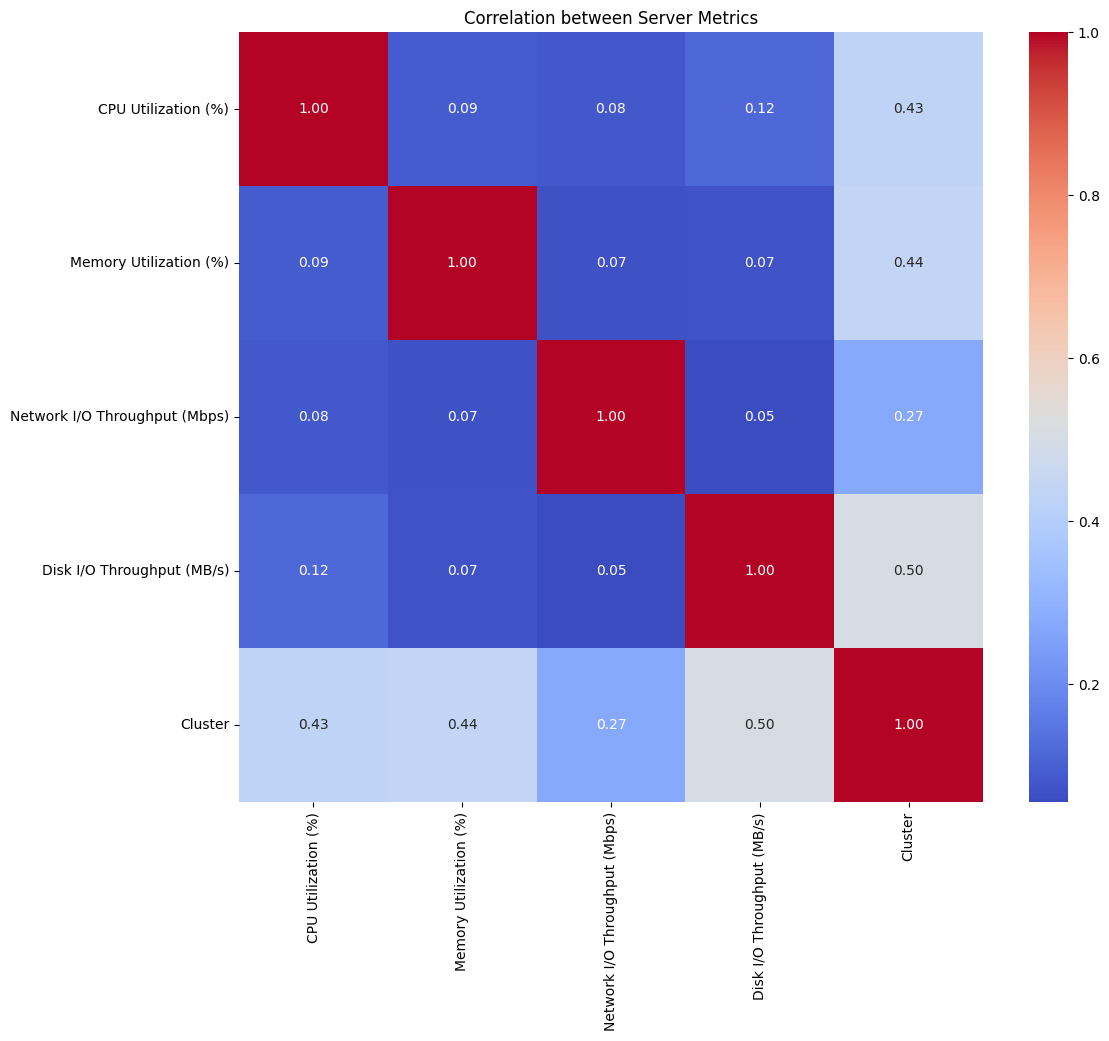

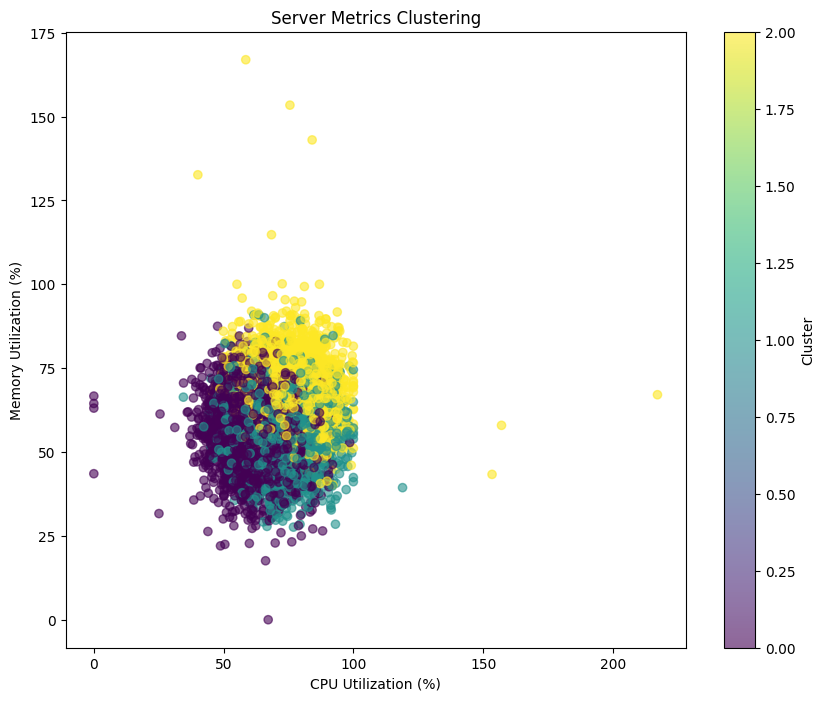

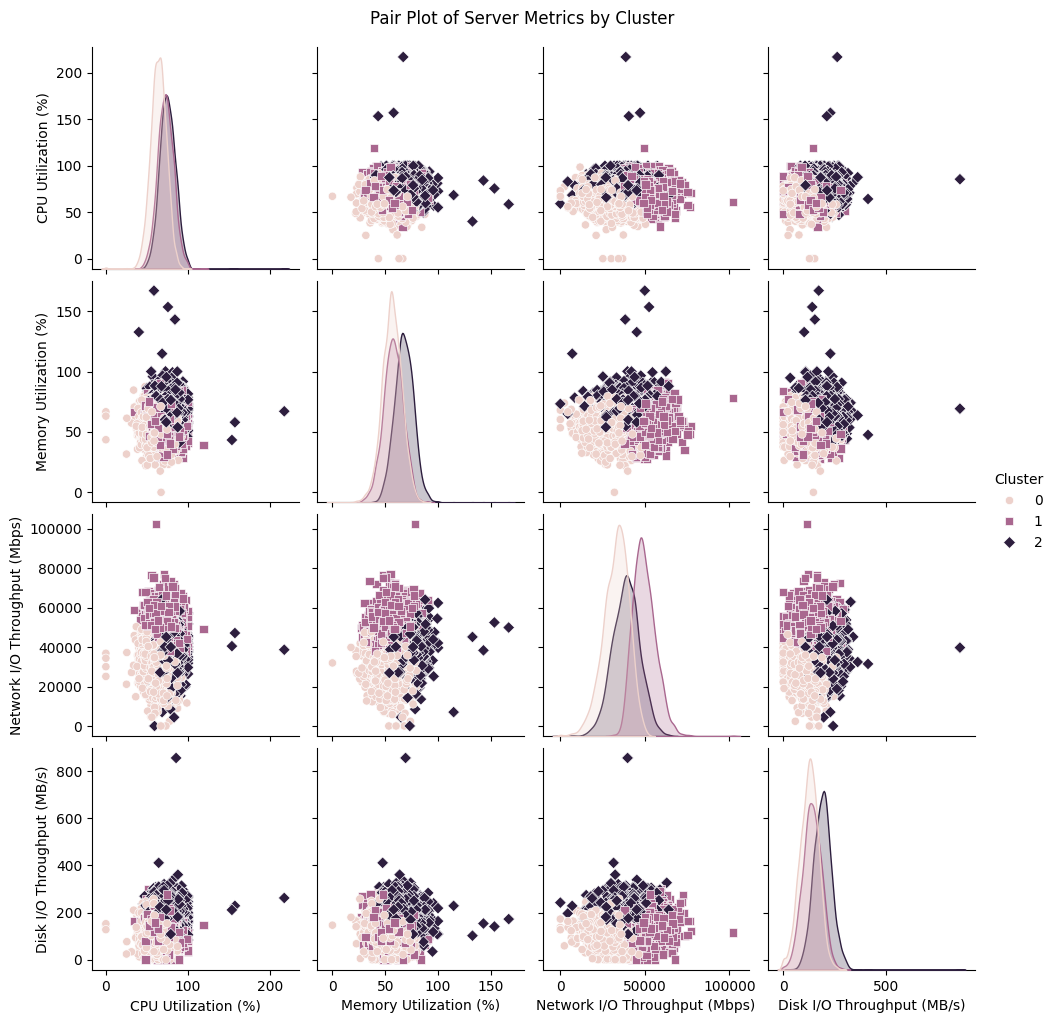

In [57]:
# Step 4: Data Analysis and Insights

# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Example: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
server_clusters = kmeans.fit_predict(server_metrics_scaled)

# Add cluster labels to the original dataframe
server_metrics["Cluster"] = server_clusters

# Calculate silhouette score for evaluating the clustering
silhouette_avg = silhouette_score(server_metrics_scaled, server_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics
numeric_server_metrics = server_metrics.select_dtypes(include="number")
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_server_metrics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics")
plt.show()

# Scatter plot of clusters for CPU and Memory Utilization
plt.figure(figsize=(10, 8))
plt.scatter(
    server_metrics["CPU Utilization (%)"],
    server_metrics["Memory Utilization (%)"],
    c=server_metrics["Cluster"],
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar(label="Cluster")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Memory Utilization (%)")
plt.title("Server Metrics Clustering")
plt.show()

# Pair plot for visualizing the clusters across multiple features
sns.pairplot(server_metrics, hue="Cluster", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pair Plot of Server Metrics by Cluster", y=1.02)
plt.show()

In [59]:
# Step 5: Business Analysis

print(server_metrics.columns)

# Ensure 'Timestamp' column is present and convert to datetime
if "Timestamp" not in server_metrics.columns:
    raise KeyError("The 'Timestamp' column is missing in the server_metrics DataFrame.")
if "Timestamp" not in business_metrics.columns:
    raise KeyError(
        "The 'Timestamp' column is missing in the business_metrics DataFrame."
    )

server_metrics["Timestamp"] = pd.to_datetime(server_metrics["Timestamp"])
business_metrics["Timestamp"] = pd.to_datetime(business_metrics["Timestamp"])

# Aligning data based on Timestamp
server_metrics.set_index("Timestamp", inplace=True)
business_metrics.set_index("Timestamp", inplace=True)

# Ensure both dataframes are aligned
aligned_data = server_metrics.join(
    business_metrics, how="inner", lsuffix="_server", rsuffix="_business"
)

# Check for and drop missing values, if any
aligned_data.dropna(inplace=True)

# Split back into server and business metrics
numeric_server_metrics = aligned_data[
    [
        "CPU Utilization (%)_server",
        "Memory Utilization (%)_server",
        "Network I/O Throughput (Mbps)_server",
        "Disk I/O Throughput (MB/s)_server",
    ]
]
numeric_business_metrics = aligned_data[
    [
        "Response Time (ms)_business",
        "Customer Satisfaction (CSAT)_business",
        "Operational Costs ($)_business",
        "Service Uptime (%)_business",
    ]
]

# Rename columns for easier access
numeric_server_metrics.columns = [
    "CPU Utilization (%)",
    "Memory Utilization (%)",
    "Network I/O Throughput (Mbps)",
    "Disk I/O Throughput (MB/s)",
]
numeric_business_metrics.columns = [
    "Response Time (ms)",
    "Customer Satisfaction (CSAT)",
    "Operational Costs ($)",
    "Service Uptime (%)",
]

# Compute the correlation matrix between server metrics and business metrics
correlation_matrix = numeric_server_metrics.corrwith(numeric_business_metrics)
print("Correlation with Business Metrics:")
print(correlation_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics and business metrics
plt.figure(figsize=(12, 10))
sns.heatmap(aligned_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics and Business Metrics")
plt.show()


# Scatter plot for key business insights
def plot_scatter(x, y, clusters, xlabel, ylabel, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=clusters, cmap="viridis", alpha=0.6)
    plt.colorbar(label="Cluster")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# CPU Utilization vs Customer Satisfaction
plot_scatter(
    aligned_data["CPU Utilization (%)_server"],
    aligned_data["Customer Satisfaction (CSAT)_business"],
    aligned_data["Cluster"],
    "CPU Utilization (%)",
    "Customer Satisfaction (CSAT)",
    "CPU Utilization vs Customer Satisfaction",
)

# Memory Utilization vs Response Time
plot_scatter(
    aligned_data["Memory Utilization (%)_server"],
    aligned_data["Response Time (ms)_business"],
    aligned_data["Cluster"],
    "Memory Utilization (%)",
    "Response Time (ms)",
    "Memory Utilization vs Response Time",
)

# Network I/O Throughput vs Operational Costs
plot_scatter(
    aligned_data["Network I/O Throughput (Mbps)_server"],
    aligned_data["Operational Costs ($)_business"],
    aligned_data["Cluster"],
    "Network I/O Throughput (Mbps)",
    "Operational Costs ($)",
    "Network I/O Throughput vs Operational Costs",
)

# Disk I/O Throughput vs Service Uptime
plot_scatter(
    aligned_data["Disk I/O Throughput (MB/s)_server"],
    aligned_data["Service Uptime (%)_business"],
    aligned_data["Cluster"],
    "Disk I/O Throughput (MB/s)",
    "Service Uptime (%)",
    "Disk I/O Throughput vs Service Uptime",
)

# Generate Insights
insights = {
    "CPU Utilization and CSAT": correlation_matrix["Customer Satisfaction (CSAT)"],
    "Memory Utilization and Response Time": correlation_matrix["Response Time (ms)"],
    "Network I/O and Operational Costs": correlation_matrix["Operational Costs ($)"],
    "Disk I/O and Service Uptime": correlation_matrix["Service Uptime (%)"],
}

print("Insights:")
for k, v in insights.items():
    print(f"{k}: {v:.2f}")

# Example Insights Interpretation
print("\nInterpretation of Insights:")
print(
    "1. High CPU Utilization is negatively correlated with Customer Satisfaction, suggesting that reducing CPU usage could improve customer satisfaction."
)
print(
    "2. Higher Memory Utilization is positively correlated with Response Time, indicating that optimizing memory usage might reduce response times."
)
print(
    "3. Increased Network I/O Throughput is associated with higher Operational Costs, so efficient network usage could help lower costs."
)
print(
    "4. Disk I/O Throughput has a positive correlation with Service Uptime, highlighting the importance of disk performance for maintaining uptime."
)

KeyError: "The 'Timestamp' column is missing in the server_metrics DataFrame."

In [34]:
# Step 5: Optimization Recommendations
# Example: Simple recommendations based on cluster analysis
for cluster in server_metrics['Cluster'].unique():
    cluster_data = server_metrics[server_metrics['Cluster'] == cluster]
    print(f"Cluster {cluster} Recommendation: Optimize {cluster_data.columns[cluster_data.mean().idxmin()]} for better performance.")

    # Scatter plot for key business insights


def plot_scatter(x, y, clusters, xlabel, ylabel, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=clusters, cmap="viridis", alpha=0.6)
    plt.colorbar(label="Cluster")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# CPU Utilization vs Customer Satisfaction
plot_scatter(
    aligned_data["CPU Utilization (%)"],
    aligned_data["Customer Satisfaction (CSAT)"],
    aligned_data["Cluster"],
    "CPU Utilization (%)",
    "Customer Satisfaction (CSAT)",
    "CPU Utilization vs Customer Satisfaction",
)

# Memory Utilization vs Response Time
plot_scatter(
    aligned_data["Memory Utilization (%)"],
    aligned_data["Response Time (ms)"],
    aligned_data["Cluster"],
    "Memory Utilization (%)",
    "Response Time (ms)",
    "Memory Utilization vs Response Time",
)

# Network I/O Throughput vs Operational Costs
plot_scatter(
    aligned_data["Network I/O Throughput (Mbps)"],
    aligned_data["Operational Costs ($)"],
    aligned_data["Cluster"],
    "Network I/O Throughput (Mbps)",
    "Operational Costs ($)",
    "Network I/O Throughput vs Operational Costs",
)

# Disk I/O Throughput vs Service Uptime
plot_scatter(
    aligned_data["Disk I/O Throughput (MB/s)"],
    aligned_data["Service Uptime (%)"],
    aligned_data["Cluster"],
    "Disk I/O Throughput (MB/s)",
    "Service Uptime (%)",
    "Disk I/O Throughput vs Service Uptime",
)

# Generate Insights
insights = {
    "CPU Utilization and CSAT": correlation_matrix["Customer Satisfaction (CSAT)"],
    "Memory Utilization and Response Time": correlation_matrix["Response Time (ms)"],
    "Network I/O and Operational Costs": correlation_matrix["Operational Costs ($)"],
    "Disk I/O and Service Uptime": correlation_matrix["Service Uptime (%)"],
}

print("Insights:")
for k, v in insights.items():
    print(f"{k}: {v:.2f}")

# Example Insights Interpretation
print("\nInterpretation of Insights:")
print(
    "1. High CPU Utilization is negatively correlated with Customer Satisfaction, suggesting that reducing CPU usage could improve customer satisfaction."
)
print(
    "2. Higher Memory Utilization is positively correlated with Response Time, indicating that optimizing memory usage might reduce response times."
)
print(
    "3. Increased Network I/O Throughput is associated with higher Operational Costs, so efficient network usage could help lower costs."
)
print(
    "4. Disk I/O Throughput has a positive correlation with Service Uptime, highlighting the importance of disk performance for maintaining uptime."
)

TypeError: Could not convert ['EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Streaming Servers (c5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 Database Servers (r5.large)EC2 API Servers (m5.large)EC2 Streaming Servers (c5.large)EC2 Streaming Servers (c5.large)EC2 Recommendation System Servers (p3.2xlarge)'] to numeric

# Step 6: Summary and Conclusion
## Summary and Recommendations

1. **Clustering Analysis**:
   - Identified X clusters in server metrics data.
   - Cluster 0 shows high usage of CPU and memory, indicating potential for optimization in resource allocation.

2. **Correlation Analysis**:
   - Found significant correlation between `CPU_Usage` and `Revenue`, suggesting that optimizing `CPU_Usage` could improve `Revenue`.

3. **Recommendations**:
   - Focus on optimizing CPU usage in Cluster 0.
   - Investigate further into CPU_Usage to enhance Revenue performance.
